# Overview
目的：モンテカルロフィルタを用いたパラメータ推定を流体シミュレーションにおいて実施し、その有用性を確認する<br>
手法：解析可能な1次元移流拡散方程式について、移流速度$u$と拡散係数$D$をMCFにより推定する

###### 目次

    1.　式の概要と解析解
    2. 数値解法とシミュレーション誤差
    3. システム方程式、観測方程式の定式化
    3. モンテカルロフィルタによるパラメータ推定

<hr>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
from numpy.random import *
from decimal import *
from tqdm import tqdm

### 1　1次元移流拡散方程式とその解析解

一次元移流拡散方程式は以下。
$$\frac{\partial C(x,t)}{\partial t} + u\frac{\partial C(x,t)}{\partial x} =  D\frac{\partial^2 C(x,t)}{\partial x^2}$$
<br>
ここで、$u$は移流速度、$D$は拡散係数である。また本項では、水平方向の境界条件に周期条件 $C(x+x_m) = C(x)$ を与える。

さらに、今回は具体例として以下の解析解を利用する。

$$C(x,t)= \frac{1}{2\sqrt{\pi D t}}exp\{-\frac{(x-2-ut)^2}{4D t}\}　$$

これは、$t=0$ で $x=2$ にデルタ関数的な分布が、時間がたつにつれて移流されつつ拡散し分布が広がっていく解である。

さらに下表のように真の値と境界を定め、初期条件として$t=0.01$を利用する。また、最終的には　$t=0.1, 0.2, 0.3$ での分布を確認することとする。

|移流速度$u$ |  拡散係数$D $ |境界$x_m$ |
|:-:|:-:|:-:|
|$10m\dot{} s$  |$1.0m^2\dot{}s$  |$10m$|

In [2]:
def Analytical_Solution(x,t, u=10, D=1):
    return np.exp(-1 * ((x-2-u * t)**2) / (4 * D * t) ) / (2 * np.sqrt(np.pi * D* t))

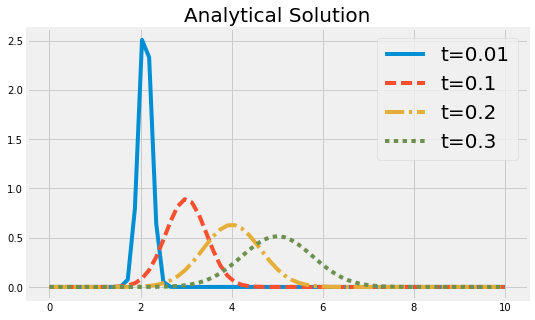

In [3]:
x = np.linspace(0,10,65)
plt.figure(figsize=(8,5))
plt.title("Analytical Solution", fontsize = 20)
plt.plot(x, Analytical_Solution(x,0.01), linestyle="-", linewidth=4, label="t=0.01")
plt.plot(x, Analytical_Solution(x,0.1),  linestyle="--",linewidth=4, label="t=0.1")
plt.plot(x, Analytical_Solution(x,0.2),linestyle="-.", linewidth=4, label="t=0.2")
plt.plot(x, Analytical_Solution(x,0.3),linestyle=":", linewidth=4, label="t=0.3")
plt.legend(loc='upper right', fontsize=20)

### 2 数値解法とシミュレーション誤差

#### 2.1 水平方向のスペクトル表現

これをスペクトル法を用いた数値計算により求める。ここで、空間方向には離散化中心差分、時間方向にはAdams-Bashforth+Crank-Nicholsonスキームを用いる（ただし、初めの1ステップ目にはオイラースキームを適用した）。<br>
ここで支配方程式の空間離散表現は以下。

$$\frac{\partial C_i(t)}{\partial t} + u\frac{\partial C_i(t)}{\partial x} =  D\frac{\partial^2 C_i(t)}{\partial x^2}$$

$C_i(t)$はスペクトル逆変換によって以下のように展開される。（ $I$: $x$方向格子点数、$K$:切断波数 ）

$$C_i(t) = \sum^{K-1}_{k=0}exp(\frac{2\pi ikx_i}{x_m}) \hat{C_k}$$

またスペクトル係数$\hat{C_k}$は以下のスペクトル変換によって与えられる。

$$\hat{C_k} = \frac{1}{I}\sum^{I}_{i=0} exp(-\frac{2\pi ikx_i}{x_m}) C_i$$

これらより支配方程式のスペクトル表現は以下のようになる。

$$\frac{\partial \hat{C_k}}{\partial t} =  -u（\frac{2\pi ik}{x_m}）\hat{C_k} +  D{(\frac{2\pi ik}{x_m})}^2\hat{C_k}$$

#### 2.2 時間方向の離散化

###### <u>2.2.1　Eulerスキーム</u>
Eularスキームを用いて上式を時間方向に離散化すると、以下のように表される。

$$\hat{C^{\tau+1}_k} = \hat{C^\tau_k} + \Delta t \{-u（\frac{2\pi ik}{x_m}）\hat{C^\tau_k} +  D{(\frac{2\pi ik}{x_m})}^2\hat{C^\tau_k} \} $$

###### <u>2.2.2 Adams-Bashforth+Crank-Nicholsonスキーム </u>
移流項に Adams-Bashforthスキーム、拡散項にCrank-Nicholsonスキームを適用して時間方向を離散化させると、以下のように表される。

$$  \{ 1 - \frac{D\Delta t}{2}(\frac{2\pi ik}{x_m})^2) \} \hat{C^{\tau+1}_k}  =\hat{C^\tau_k} - \frac{u \Delta t}{2}(\frac{2\pi ik}{x_m})(3\hat{C^{\tau}_k}-\hat{C^{\tau-1}_k}) + \frac{D \Delta t}{2} (\frac{2\pi ik}{x_m})^2 \hat{C^{\tau}_k}$$

#### 2.3　数値解析

ここで、下のように仕様を定めた。

|時間格子間隔$\Delta t$ |格子点数 $I$　|切断波数 $K$| 
|:-:|:-:|:-:|
|$0.001s $ | $64$| $64$ |

#安定性解析
def isSustainable(dt,dx):
    euler = np.absolute(0.01 * ((2*np.pi/dx)**2) * dt)
    if (euler<1):
        print('clear')
    print('euler: ', euler)
isSustainable(0.001,10/100)

In [26]:
#各変数の設定
x_m = 10.0
I = 64
K = I
true_u = 10
true_D = 1.0
x = np.linspace(0, x_m, I+1, dtype='f16')[:-1]
dt = 0.001

#解
ans = pd.DataFrame(None)
ans['Time'] = np.arange(0.01, 0.3101, dt)
C_hats = np.empty([len(ans), K], dtype='c32')

#オイラー法ステップ
def Step(C_hat, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = C_hat + dt*(-1*u*p*C_hat + D*(p**2)*C_hat)
    return newC_hat

#Adams-Bashforth+Crank-Nicholsonスキーム
def AC_Step(C_hat, C_hat_1, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = (1/(1-D*dt*(p**2)/2))*(C_hat - u*dt*p*(3*C_hat-C_hat_1)/2+D*dt*(p**2)*C_hat/2)
    return newC_hat

#初期値はt=0.01
C0 = Analytical_Solution(x,0.01, u=true_u, D=true_D)
C_hats[0] = np.fft.fft(C0, n=K)

#計算
for i in range(0, len(ans)-1):
    if(i==0):
        C_hats[i+1] = Step(C_hats[i], true_u, true_D, dt, x_m)
    else:
        C_hats[i+1] = AC_Step(C_hats[i], C_hats[i-1], true_u, true_D, dt, x_m)

#結果格納
tmp = pd.DataFrame(C_hats)
ans = pd.concat([ans, tmp], axis=1)
ans.set_index('Time', inplace=True)

In [5]:
ans[0.01:0.011]

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Time,,,,,,,,,,,,,,,,,,,,,
0.010,(6.39999887049+0j),(1.58534413045-6.17450678055j),(-5.52049287388-3.03491723844j),(-4.22817025626+4.50254263907j),(3.21937461696+5.07292556825j),(5.51471065635-1.79183546326j),(-0.348614407794-5.54113125316j),(-5.1809010141-0.988316167913j),(-2.11657910474+4.49793632172j),(3.58161317778+2.96298800569j),...,(3.48883761384+2.53475974954j),(3.58161317778-2.96298800569j),(-2.11657910474-4.49793632172j),(-5.1809010141+0.988316167913j),(-0.348614407794+5.54113125316j),(5.51471065635+1.79183546326j),(3.21937461696-5.07292556825j),(-4.22817025626-4.50254263907j),(-5.52049287388+3.03491723844j),(1.58534413045+6.17450678055j)
0.011,(6.39999887049+0j),(1.54592269139-6.18203019393j),(-5.54991315576-2.96075212981j),(-4.1282763946+4.56624397749j),(3.32653581205+4.95997048723j),(5.4039904725-1.94740050093j),(-0.552555546382-5.44923696591j),(-5.12414788031-0.741329832387j),(-1.83701028144+4.49068149016j),(3.63463510132+2.66570354898j),...,(0.332544069438-1.5669667074j),(-1.71956369794-0.662238812074j),(-1.07879936242+1.81543913681j),(1.81835839334+1.57614467583j),(2.1336896994-1.69074637833j),(-1.39959819207-2.71493015287j),(-3.26852262664+0.923157460385j),(0.257268787551+3.73220512399j),(4.0394078833+0.579826794336j),(1.54539188518-4.12786167174j)


In [27]:
#t=0.1, 0.2, 0.3を逆rfftで復元
C1 = np.fft.irfft(np.array(ans[0.1:0.1+dt]), n=I)[0]
C2 = np.fft.irfft(np.array(ans[0.2:0.2+dt]),n=I)[0]
C3 = np.fft.irfft(np.array(ans[0.3- dt/2:]), n=I)[0]

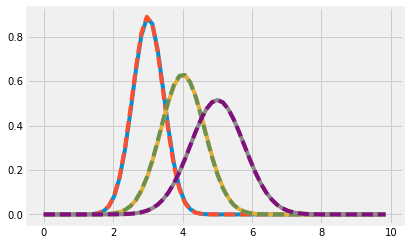

In [7]:
plt.plot(x, C1,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.1),  linestyle="--",linewidth=4, label="True")
plt.plot(x, C2,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.2),  linestyle="--",linewidth=4, label="True")
plt.plot(x, C3,linewidth=4)
plt.plot(x, Analytical_Solution(x,0.3),  linestyle="--",linewidth=4, label="True")

解析解とシミュレーション解はほぼ一致した。

#### 2.4 シミュレーション誤差評価

In [28]:
#誤差の評価
e_1= C1 - Analytical_Solution(x,0.1)
e_2 =C2 - Analytical_Solution(x,0.2)
e_3 = C3 - Analytical_Solution(x,0.3)

def rmse(e):
    return np.sqrt(np.sum(e**2)/len(e))
def mae(e):
    return np.sum(np.abs(e)) / len(e)

print("at t=0.1 :    rmse is", rmse(e_1), " , mae is", mae(e_1))
print("at t=0.2 :    rmse is", rmse(e_2), " , mae is", mae(e_2))
print("at t=0.3 :    rmse is", rmse(e_3), " , mae is", mae(e_3))

at t=0.1 :    rmse is 0.00424312918608  , mae is 0.00186014052071
at t=0.2 :    rmse is 0.00247995786401  , mae is 0.0013043379081
at t=0.3 :    rmse is 7.42144923101e-05  , mae is 4.24034350334e-05


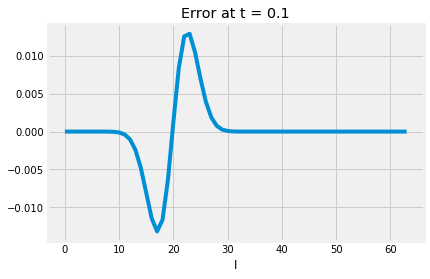

In [29]:
plt.plot(e_1)
plt.title("Error at t = 0.1")
plt.xlabel("I")

誤差はかなり系統的。

##### 誤差分布の近似計算：観測誤差分布と尤度の問題

まず、解析解を$y^\tau_i$と書き、iごとのモデル誤差 $y^\tau_i - C^\tau_i$ の分布を確認する。ここでこの確率密度変数を $f_i(y^\tau_i - C^\tau_i)$ とおき、これを近似的にシミュレーション結果から求めることを考える。

In [10]:
error = np.empty([len(ans), I])
for i in range(len(ans)):
    time = 0.01 + i*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    c = np.fft.irfft(np.array(ans[time - 0.0005: time+0.0005]), n=I)[0]
    error[i] = y - c
error = error.T

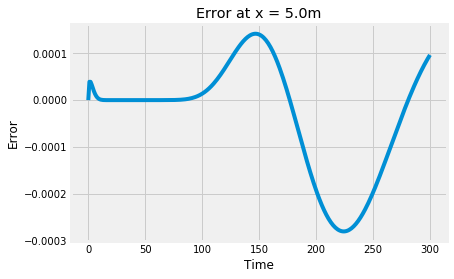

In [11]:
#i = 0における誤差の分布
plt.plot(error[32])
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Error at x = 5.0m")

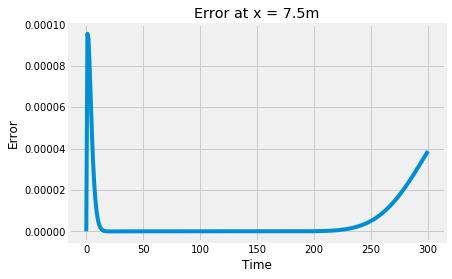

In [12]:
#i = 0における誤差の分布
plt.plot(error[48])
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Error at x = 7.5m")

誤差は一つの確率分布から発生したiidサンプルとみなすには系統的すぎる。そこで、$f_i(y^\tau_i - C^\tau_i)$の分布推定を諦め、ある時刻における状態の尤度をMAEの値から求めることを考える。（MSE等他の指標でも代替できるが、外れ値の影響が比較的小さいMAEを用いることとする）

The Errors are too systematic to regard as i.i.d sample from one distribution.
Here, We try to calculate the likelihood from the distribution of MAE.

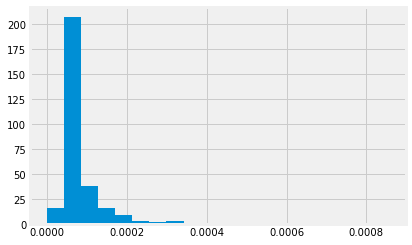

In [13]:
mae_s = np.empty(len(ans))
for i in range(len(ans)):
    time = 0.01 + i*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    c = np.fft.irfft(np.array(ans[time - 0.0005: time+0.0005]), n=I)[0]
    e = y - c
    mae_s[i] = mae(e)
plt.hist(mae_s, bins = 20)
plt.show()

In [14]:
mae_s.max()

0.00085544314401628328

ここでは、多少恣意的にはなってしまうが、0 ~ 0.0004を10階級に分け、その度数/総数を、モデル誤差&観測誤差がその階級に含まれる実現確率とみなす。また、確率密度関数 $f_{MAE}(x)$ の導出においては、$max(MAE) \approx 0.00086$ より、$f_{MAE}(x>0.001)=0$と仮定する。なお、実際の応用研究においては、真の値は分からないので、この誤差分布の評価が非常に難しく、また重要になることを付記しておく。

In [15]:
dosuu = np.zeros(11)
for mae in mae_s:
    for j in range(10):
        high = 0.00004 * (j+1)
        if mae < high:
            dosuu[j] += 1
            break
        if j == 9:
            dosuu[10] += 1

dosuu = dosuu/dosuu.sum()
for i in range(10):
    dosuu[i] = dosuu[i] / 0.00004
dosuu[10] = dosuu[10] / (0.001-0.0004)
dosuu

array([    83.05647841,  17524.91694352,   3737.54152824,   1411.96013289,
          830.56478405,    332.22591362,    166.11295681,    166.11295681,
          249.16943522,      0.        ,     33.22259136])

In [3]:
def f_mae(mae):
    dosuu = np.array([83.05647841, 17524.91694352, 3737.54152824, 1411.96013289, 830.56478405, 332.22591362
                      , 166.11295681, 166.11295681, 249.16943522, 0. , 33.22259136])
    if mae > 0.001:
        return 0.0000000000000000001
    for i in range(10):
        high = 0.00004  * (i + 1)
        if mae < high:
            return dosuu[i]
    return dosuu[10]

array_f_mae = np.frompyfunc(f_mae,1,1)

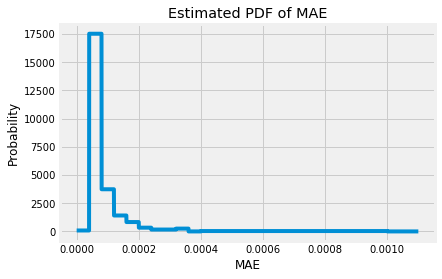

In [17]:
x = np.linspace(0,0.0011,10000)
plt.plot(x,array_f_mae(x))
plt.xlabel("MAE")
plt.ylabel("Probability")
plt.title("Estimated PDF of MAE")

### 3. 状態空間モデルの定式化

#### 3.1 自己組織化

以上の結果を以って、状態空間モデルを定式化する。まず、各パラメータについては、Liu and West (2001)に従い、以下のように状態化する。<br>

$$p(\theta_{t+1}|\theta_t) ∼ N(a\theta_t + (1 − a)\overline{\theta_t}, h^2V_t)$$

ここで $\overline{θ_t}$ は $θ_t$を表す粒子の値の平均、$V_t$ は同じく分散、また $h^2 = 1 − a^2$, $a = (3δ_l − 1)/2δ_l$ である。ここで　$δ_l　= (0,1]$ であるが、$δ_l　=0.97$を使用する。

#### 3.2 モデル式

自己組織化を行い、1次元移流拡散方程式における状態変数を$u_\tau, D_\tau, \hat{C^\tau_k} (k=0,1,...,63)$ とする。さらに、実際の波の変位 $y^\tau_i$ を観測系列として扱い、観測誤差 $\epsilon^{\tau}_i$ の平均絶対誤差、${mae}_{\tau}$ は前章で求めた $f_{MAE}$ に従うものとする。この時、システム方程式は以下のように書ける。

<b>3.2.1 システム方程式</b>

$$D_\tau \sim N(aD_{\tau-1} + (1 − a)\overline{D_{\tau-1}}, h^2V_{\tau - 1}) $$
$$u_\tau \sim N(au_{\tau-1} + (1 − a)\overline{u_{\tau-1}}, h^2V_{\tau - 1}) $$
<br>
$$ h^2 = 0.1418756775, a = 0.92635$$
<br>
$\tau=0$のとき、
$$\hat{C^{\tau}_k} = \hat{C^{\tau-1}_k} + \Delta t \{-u_{\tau-1}（\frac{2\pi ik}{x_m}）\hat{C^{\tau-1}_k} +  D_{\tau-1}{(\frac{2\pi ik}{x_m})}^2\hat{C^{\tau-1}_k} \}$$
$\tau \geqq 1$のとき、
$$  \{ 1 - \frac{D_{\tau-1}\Delta t}{2}(\frac{2\pi ik}{x_m})^2) \} \hat{C^{\tau+1}_k}  =\hat{C^\tau_k} - \frac{u_{\tau-1}\Delta t}{2}(\frac{2\pi ik}{x_m})(3\hat{C^{\tau}_k}-\hat{C^{\tau-1}_k}) + \frac{D_{\tau-1} \Delta t}{2} (\frac{2\pi ik}{x_m})^2 \hat{C^{\tau}_k}$$


<b>3.2.2. 観測方程式</b>

$$ y^{\tau}_i = C_i(t) + \epsilon^{\tau}_i  $$

ここで
$$C_i(t) = \sum^{K-1}_{k=0}exp(\frac{2\pi ikx_i}{x_m}) \hat{C_k}$$
$${mae}_\tau = \frac{1}{I}  \sum_{i=0}^{I} | \epsilon^{\tau}_i | \sim f_{MAE} $$
である。

<b>3.2.3 初期条件</b>

ここで、各係数の範囲についてはある程度事前情報が与えられているとし、$u_0 \sim Uniform(3, 20)$、$D_0 \sim Uniform(0.5, 2)$ とする。また、$C_k^0(k=0,...,63)$は真の値を得ているものとする。粒子数は10000とする。

### 4. モンテカルロフィルタによるパラメータ推定

In [19]:
#各変数の設定
x_m = 10.0
I = 64
K = I
true_u = 10
true_D = 1.0
x = np.linspace(0, x_m, I+1, dtype='f16')[:-1]
dt = 0.001
total_step = 50
m = 10000

#初期値
u_0 = np.random.uniform(3,20,m)
D_0 = np.random.uniform(0.5,2,m)
C_hat_0 = np.fft.fft(Analytical_Solution(x,0.01, u=true_u, D=true_D), n=K)
#粒子の格納
C_hats = np.empty([m, K], dtype='c32')
C_hats_1 = np.empty([m,K], dtype='c32')
sim_u = np.empty([total_step+1, len(u_0)])
sim_D = np.empty([total_step+1, len(u_0)])
for i in range(m):
    C_hats_1[i] = C_hat_0
sim_u[0] = u_0
sim_D[0] = D_0

#パラメータのシステム方程式
def system_equation(param_samples):
    
    a = 0.92635
    h2=0.1418756775
    v = h2 * param_samples.var()
    mu = param_samples.mean()
    new_samples = np.empty(len(param_samples))
    for i in range(len(param_samples)):
        x = a * param_samples[i] + (1 - a) * mu
        new_samples[i] = np.random.normal(x, v)
    
    return new_samples

#C_hatのシステム方程式：　オイラースキーム
def Euler_Step(C_hat, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = C_hat + dt*(-1*u*p*C_hat + D*(p**2)*C_hat)
    return newC_hat

#C_hatのシステム方程式：　Adams-Bashforth+Crank-Nicholsonスキーム
def AC_Step(C_hat, C_hat_1, u, D, dt =0.0001, x_m=5.0):
    newC_hat = np.empty(len(C_hat), dtype='c32')
    p = (1/x_m)*2*np.pi*1j* np.arange(len(C_hat))
    newC_hat = (1/(1-D*dt*(p**2)/2))*(C_hat - u*dt*p*(3*C_hat-C_hat_1)/2+D*dt*(p**2)*C_hat/2)
    return newC_hat


#尤度の計算
#C_hats_samples = [C_hats_sample1, ..., C_hats_sample10000]
def obs_L(C_hats_samples, step):
    def MAE(e):
        return np.sum(np.abs(e)) / len(e)
    
    w = np.empty(len(C_hats_samples))
    time = 0.01 + step*dt
    y = Analytical_Solution(x,time, u=true_u, D=true_D)
    for i in range(len(C_hats_samples)):
        c = np.fft.irfft(C_hats_samples[i], n=I)
        mae = MAE(y - c)
        w[i] = f_mae(mae)
        
    return w

def Resampling(w, C_hats, C_hats_1, sim_u_t, sim_D_t):
    
    new_C_hats = np.empty([m, K], dtype='c32')
    new_C_hats_1 = np.empty([m, K], dtype='c32')
    new_sim_u_t = np.empty(m)
    new_sim_D_t = np.empty(m)
    
    u_t = rand(m)
    w = w / np.sum(w)
    w = w.cumsum()

    for i in range(m):
        u = u_t[i]
        j = np.where(w > u)[0][0]

        new_C_hats[i] = C_hats[j]
        new_C_hats_1[i] = C_hats_1[j]
        new_sim_u_t[i] = sim_u_t[j]
        new_sim_D_t[i] = sim_D_t[j]

    return new_C_hats, new_C_hats_1, new_sim_u_t, new_sim_D_t


#Total Calculation
for t in tqdm(range(0, total_step)):

    #Update Variables
    for i in range(m):
        if(t==0):
            C_hats[i] = Euler_Step(C_hats_1[i], sim_u[t][i], sim_D[t][i], dt, x_m)
        else:
            tmp = C_hats[i]
            C_hats[i] = AC_Step(C_hats[i], C_hats_1[i], sim_u[t][i], sim_D[t][i], dt, x_m)
            C_hats_1[i] = tmp
    sim_u[t+1] = system_equation(sim_u[t])
    sim_D[t+1] = system_equation(sim_D[t])

    #Likelihood
    w = obs_L(C_hats, t+1)
    
    #Resampling -- with high speed1
    C_hats, C_hats_1, sim_u[t+1], sim_D[t+1] = Resampling(w, C_hats, C_hats_1, sim_u[t+1], sim_D[t+1])

100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


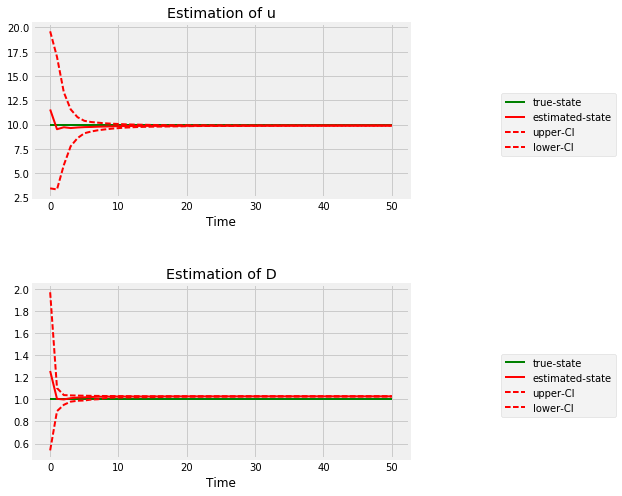

In [20]:
#結果の表示
Per_CI=0.95
    
T = total_step
num_variables = 2
m = 10000   #mは粒子の個数
ave_x = np.full([T+1,num_variables], 100, dtype=np.float)
mid_x = np.full([T+1,num_variables], 100, dtype=np.float)
lower_CI = np.full([T+1,num_variables], 100, dtype=np.float)
upper_CI = np.full([T+1,num_variables], 100, dtype=np.float)
low = int(m * (1- Per_CI) / 2) - 1
high = int(m - low) - 1

for t in range(T+1):
    u_t = sim_u[t]
    D_t = sim_D[t]
    for k in range(num_variables):
        if k == 0:
            x_t = np.sort(u_t)
        else:
            x_t = np.sort(D_t)
            
        ave_x[t][k] = np.average(x_t)
        mid_x[t][k] = np.median(x_t)
        lower_CI[t][k] = x_t[low]
        upper_CI[t][k] = x_t[high]

#結果のプロット
plt.figure(figsize=(6,num_variables*4))
plt.subplots_adjust(hspace=0.5)
for k in range(num_variables):
    plt.subplot(num_variables,1,k+1)

    if k == 0:
        plt.title("Estimation of u")
        plt.plot(np.full(T+1,10, dtype=np.float), color = 'green', linewidth=2, label="true-state")
    else:
        plt.title("Estimation of D")
        plt.plot(np.full(T+1,1, dtype=np.float), color = 'green', linewidth=2, label="true-state")
    plt.plot(ave_x.T[k], color = 'red', linewidth=2, label="estimated-state")
    plt.plot(upper_CI.T[k],'--', color = 'red', linewidth=2, label="upper-CI")
    plt.plot(lower_CI.T[k], '--', color = 'red', linewidth=2, label="lower-CI")
    plt.xlabel("Time")
    plt.legend(loc='upper right', bbox_to_anchor=(1.05,0.5,0.5,.100), borderaxespad=0.)

plt.show()

In [24]:
print("パラメータu(=10)の推定値：　",sim_u[50].mean())
print("パラメータD(=1.0)の推定値：　",sim_D[50].mean())

パラメータu(=10)の推定値：　 9.89992632473
パラメータD(=1.0)の推定値：　 1.02693305336


#### まとめ

パラメータ推定の収束速度は非常に早く、有効な精度で逐次的にパラメータ推定を行うことが出来た。
一方、より高い精度を求めるにはパラメータの収束速度を遅くする（MCMCなどで散らす）ことが有効であり、また、誤差分布をより正確に推定することが必要であることが考えられる。